# 今回の取り組み

- Tyr50%,10%, 01%のアルビノアレルが無くなったので原因を調べます

## いつものセットアップ

In [1]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if Path(os.getcwd()).stem != "DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)

print(os.getcwd())
sys.path.append(os.getcwd() + "/" + "src")

/mnt/d/Research/DAJIN2


In [2]:
%%bash
# pipの更新
pip install -q -U pip
pip install -q -U -r requirements.txt

# 実験

In [3]:
from __future__ import annotations

import sys, os
from pathlib import Path

import hashlib
from collections import defaultdict
from pathlib import Path
from importlib import reload

from src.DAJIN2.core import preprocess, classification, clustering, consensus, report

reload(preprocess)
reload(classification)
reload(clustering)
reload(consensus)
reload(report)

#### # * Subset of Point mutation
#### # 50 or 10 or 01%
percent = "50"
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    f"misc/data/tyr_albino_{percent}%.fq.gz",
    "misc/data/tyr_control.fq.gz",
    "misc/data/tyr_control.fasta",
    "batch_tyr_50_10_01",
    "mm10",
    True,
    30,
)


######################################################################
# Preprocessing
######################################################################

print(f"processing {NAME}...")

SAMPLE = preprocess.format_inputs.convert_to_posix_path(SAMPLE)
CONTROL = preprocess.format_inputs.convert_to_posix_path(CONTROL)
ALLELE = preprocess.format_inputs.convert_to_posix_path(ALLELE)

# ====================================================================
# Varidate inputs
# ====================================================================

preprocess.validate_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.validate_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.validate_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.validate_inputs.check_and_fetch_genome(GENOME)

# ====================================================================
# Format inputs
# ====================================================================
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = preprocess.format_inputs.update_threads(THREADS)

preprocess.format_inputs.make_directories(TEMPDIR, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)


processing batch_tyr_50_10_01...


In [4]:
MUTATION_LOCI_ALLELES = preprocess.extract_mutation_loci(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
KNOCKIN_LOCI_ALLELES = preprocess.extract_knockin_loci(TEMPDIR)
classif_sample = classification.classify_alleles(TEMPDIR, SAMPLE_NAME)

In [5]:
print(KNOCKIN_LOCI_ALLELES.keys())

dict_keys([])


- knockin_alleleはありません。これは想定通りです。

In [10]:
clust_sample = clustering.add_labels(classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI_ALLELES, KNOCKIN_LOCI_ALLELES, THREADS)

In [11]:
count = defaultdict(int)
for samp in clust_sample:
    count[samp["LABEL"]] += 1
print(count)

defaultdict(<class 'int'>, {1: 5000})


- やはりクラスタリングされていません😭

In [36]:
from __future__ import annotations

from collections import defaultdict
from itertools import groupby
from pathlib import Path

import midsv

from DAJIN2.core.clustering.make_score import make_score
from DAJIN2.core.clustering.return_labels import return_labels


def _compress_insertion(cssplits: list[list[str]]) -> list[dict[str, int]]:
    """Insertion will be subdivided by sequence error in the its sequence, so it is compressed as a '+I' to eliminate mutations.
    #TODO ただ、これでは、insertion配列の中に真のmutationがある場合に、そのmutationを抽出できないので、**insertion配列の中にmutationがある場合は、insertion配列をそのまま残す**必要がある。
    """
    cssplits_abstracted = []
    for cssplit in cssplits:
        for i, cs in enumerate(cssplit):
            if cs.startswith("+"):
                cssplit[i] = "+I" + cs.split("|")[-1]
        cssplits_abstracted.append(cssplit)
    return cssplits_abstracted


def _transpose_mutation_loci(mutation_loci, cssplits_sample):
    mutation_loci_transposed = [set() for _ in range(len(cssplits_sample[0]))]
    for mut, values in mutation_loci.items():
        for i, loci in enumerate(mutation_loci_transposed):
            if i in values:
                loci.add(mut)
    return mutation_loci_transposed


def _extract_cssplits_in_mutation_by_3mer(cssplits_sample: list[list], mutation_loci_transposed: list[set[str]]) -> list[list]:
    cssplits_mutation = []
    for cssplits in cssplits_sample:
        cs_mutation = []
        for i in range(1, len(cssplits) - 1):
            if mutation_loci_transposed[i] == set():
                cs_mutation.append("N,N,N")
                continue
            mutation = ""
            if cssplits[i].startswith("+"):
                mutation = "ins"
            elif cssplits[i].startswith("-"):
                mutation = "del"
            elif cssplits[i].startswith("*"):
                mutation = "sub"
            if mutation in mutation_loci_transposed[i]:
                kmer = ",".join([cssplits[i - 1], cssplits[i], cssplits[i + 1]])
                cs_mutation.append(kmer)
            else:
                cs_mutation.append("N,N,N")
        cssplits_mutation.append(cs_mutation)
    return cssplits_mutation


def _annotate_score(cssplits: list[list[str]], mutation_score: list[dict[str:float]]) -> list[list[float]]:
    scores = []
    for cssplit in cssplits:
        score = [0 for _ in range(len(cssplit))]
        for i, (cs, mutscore) in enumerate(zip(cssplit, mutation_score)):
            if mutscore == {}:
                continue
            if cs in mutscore:
                score[i] = mutscore[cs]
        scores.append(score)
    return scores

# def _annotate_score(cssplits: list[list[str]], mutation_score: list[dict[str:float]]) -> list[list[float]]:
#     scores = []
#     for cssplit in cssplits:
#         score = []
#         for cs, mutscore in zip(cssplit, mutation_score):
#             if mutscore == {}:
#                 score.append(0)
#                 continue
#             mutation = list(mutscore.keys())[0]
#             value = list(mutscore.values())[0]
#             if cs == mutation:
#                 score.append(value)
#             else:
#                 score.append(0)
#         scores.append(score)
#     return scores


def _reorder_labels(labels: list[int], start: int = 0) -> list[int]:
    labels_ordered = labels.copy()
    num = start
    d = defaultdict(int)
    for i, l in enumerate(labels_ordered):
        if not d[l]:
            num += 1
            d[l] = num
        labels_ordered[i] = d[l]
    return labels_ordered


def add_labels(classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI_ALLELES, KNOCKIN_LOCI_ALLELES, THREADS: int = 1) -> list[dict[str]]:
    labels_all = []
    max_label = 0
    classif_sample.sort(key=lambda x: x["ALLELE"])
    for allele, group in groupby(classif_sample, key=lambda x: x["ALLELE"]):
        mutation_loci: dict[str, set[int]] = MUTATION_LOCI_ALLELES[allele]
        if mutation_loci == {}:
            labels_all.extend([1] * len(classif_sample))
            continue
        knockin_loci = set()
        if allele in KNOCKIN_LOCI_ALLELES:
            knockin_loci = KNOCKIN_LOCI_ALLELES[allele]
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in group]
        midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        cssplits_sample = _compress_insertion(cssplits_sample)
        cssplits_control = _compress_insertion(cssplits_control)
        mutation_loci_transposed = _transpose_mutation_loci(mutation_loci, cssplits_sample)
        cssplits_mutation_loci_sample = _extract_cssplits_in_mutation_by_3mer(cssplits_sample, mutation_loci_transposed)
        cssplits_mutation_loci_control = _extract_cssplits_in_mutation_by_3mer(cssplits_control, mutation_loci_transposed)
        mutation_score = make_score(cssplits_mutation_loci_sample, cssplits_mutation_loci_control, knockin_loci)
        scores_sample = _annotate_score(cssplits_mutation_loci_sample, mutation_score)
        scores_control = _annotate_score(cssplits_mutation_loci_control, mutation_score)
        labels = return_labels(scores_sample, scores_control)
        labels_reorder = _reorder_labels(labels, start=max_label)
        max_label = max(labels_reorder)
        labels_all.extend(labels_reorder)
    clust_sample = classif_sample.copy()
    for clust, label in zip(clust_sample, labels_all):
        clust["LABEL"] = label
    return clust_sample


def add_readnum(clust_sample: list[dict]) -> list[dict]:
    clust_result = clust_sample.copy()
    readnum = defaultdict(int)
    for cs in clust_result:
        readnum[cs["LABEL"]] += 1
    for cs in clust_result:
        cs["READNUM"] = readnum[cs["LABEL"]]
    return clust_result


def add_percent(clust_sample: list[dict]) -> list[dict]:
    clust_result = clust_sample.copy()
    n_sample = len(clust_result)
    percent = defaultdict(int)
    for cs in clust_result:
        percent[cs["LABEL"]] += 1 / n_sample
    percent = {key: round(val * 100, 3) for key, val in percent.items()}
    for cs in clust_result:
        cs["PERCENT"] = percent[cs["LABEL"]]
    return clust_result


def update_labels(clust_sample: list[dict]) -> list[dict]:
    """
    Allocate new labels according to the ranking by PERCENT
    """
    clust_result = clust_sample.copy()
    clust_result.sort(key=lambda x: (-x["PERCENT"], x["LABEL"]))
    new_label = 1
    prev_label = clust_result[0]["LABEL"]
    for cs in clust_result:
        if prev_label != cs["LABEL"]:
            new_label += 1
        prev_label = cs["LABEL"]
        cs["LABEL"] = new_label
    return clust_result


In [14]:
allele = "control"
import midsv
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in classif_sample if cs["ALLELE"] == allele]
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
mutation_loci: dict[str, set[int]] = MUTATION_LOCI_ALLELES[allele]
if mutation_loci == {}:
    labels_all.extend([1] * len(classif_sample))
    continue
knockin_loci = set()
if allele in KNOCKIN_LOCI_ALLELES:
    knockin_loci = KNOCKIN_LOCI_ALLELES[allele]


SyntaxError: 'continue' not properly in loop (1154354874.py, line 9)

In [15]:
MUTATION_LOCI_ALLELES[allele]

{'ins': set(), 'del': {1077, 1105}, 'sub': set()}

- 🤯 MUTATION_LOCI_ALLELESに点変異の情報がありません！
- まさかの`preprocess.extract_mutation_loci`の問題だったとは…

In [13]:
# いったん補正前にリセットします
import shutil
shutil.copytree(Path(TEMPDIR, "midsv_control"), Path(TEMPDIR, "midsv"), dirs_exist_ok=True)
for allele in FASTA_ALLELES:
    preprocess.call_midsv(TEMPDIR, SAMPLE_NAME, allele)
preprocess.replace_NtoD(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)

In [14]:
import midsv
allele = "control"
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl")))
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))

In [15]:
idx_mutation = 828
count_mutation = defaultdict(int)
for samp in midsv_sample:
    count_mutation[samp["CSSPLIT"].split(",")[idx_mutation]] += 1

print(count_mutation)

defaultdict(<class 'int'>, {'=G': 2501, '*GT': 2475, '+T|=G': 1, '-G': 9, 'N': 8, '*GA': 4, '+A|=G': 1, '+A|+A|*GA': 1})


In [16]:
count_mutation = defaultdict(int)
for cont in midsv_control:
    count_mutation[cont["CSSPLIT"].split(",")[idx_mutation]] += 1

print(count_mutation)

defaultdict(<class 'int'>, {'=G': 9949, '+T|=G': 1, '-G': 16, '*GA': 7, '+A|=G': 3, 'N': 12, '*GT': 8, '+A|+A|*GA': 1, '+C|+A|*GA': 1, '+A|*GT': 2})


In [17]:
MUTATION_LOCI_ALLELES = preprocess.extract_mutation_loci(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
# 35秒くらい

In [18]:
print(828 in MUTATION_LOCI_ALLELES["control"]["sub"])

True


- やり直したところ、点変異部位はたしかにありました…
- なんか変な感じがします
    - 補正されてしまっているような気がします？

In [19]:
preprocess.correct_sequence_error(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME, MUTATION_LOCI_ALLELES)
# 25秒くらい

In [20]:
KNOCKIN_LOCI_ALLELES = preprocess.extract_knockin_loci(TEMPDIR)

In [21]:
classif_sample = classification.classify_alleles(TEMPDIR, SAMPLE_NAME)

In [22]:
idx_mutation = 828
count_mutation = defaultdict(int)
for samp in classif_sample:
    count_mutation[samp["CSSPLIT"].split(",")[idx_mutation]] += 1

print(count_mutation)

defaultdict(<class 'int'>, {'=G': 2503, '*GT': 2476, '*GA': 4, 'N': 8, '-G': 9})


- 間違って補正されている、ということはなさそうです

In [32]:
clust_sample = clustering.add_labels(classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI_ALLELES, KNOCKIN_LOCI_ALLELES, THREADS)

In [33]:
count = defaultdict(int)
for samp in clust_sample:
    count[samp["LABEL"]] += 1
print(count)

defaultdict(<class 'int'>, {1: 5000})


In [23]:
allele = "control"
import midsv
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in classif_sample if cs["ALLELE"] == allele]
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
mutation_loci: dict[str, set[int]] = MUTATION_LOCI_ALLELES[allele]
knockin_loci = set()
if allele in KNOCKIN_LOCI_ALLELES:
    knockin_loci = KNOCKIN_LOCI_ALLELES[allele]


In [24]:
print(828 in mutation_loci["sub"])
print(knockin_loci)

True
set()


In [25]:
cssplits_sample = _compress_insertion(cssplits_sample)
cssplits_control = _compress_insertion(cssplits_control)
mutation_loci_transposed = _transpose_mutation_loci(mutation_loci, cssplits_sample)
cssplits_mutation_loci_sample = _extract_cssplits_in_mutation_by_3mer(cssplits_sample, mutation_loci_transposed)
cssplits_mutation_loci_control = _extract_cssplits_in_mutation_by_3mer(cssplits_control, mutation_loci_transposed)
mutation_score = make_score(cssplits_mutation_loci_sample, cssplits_mutation_loci_control, knockin_loci)
scores_sample = _annotate_score(cssplits_mutation_loci_sample, mutation_score)
scores_control = _annotate_score(cssplits_mutation_loci_control, mutation_score)
labels = return_labels(scores_sample, scores_control)


In [26]:
from collections import defaultdict
from collections import Counter
print(Counter(labels))

Counter({1: 5000})


In [27]:
print(mutation_loci_transposed[idx_mutation])
print(mutation_score[idx_mutation])

{'sub', 'del'}
{}


In [28]:
count = defaultdict(int)
for samp in cssplits_sample:
    count[samp[idx_mutation]] += 1
print(count)

defaultdict(<class 'int'>, {'=G': 2503, '*GT': 2476, '*GA': 4, 'N': 8, '-G': 9})


In [29]:
print(mutation_loci_transposed[idx_mutation])
cssplits = cssplits_sample[0]
print(cssplits[idx_mutation])
cssplits = cssplits_sample[1]
print(cssplits[idx_mutation])

{'sub', 'del'}
=G
*GT


In [38]:
print(len(cssplits_sample[0]))
print(len(mutation_loci_transposed))
print(len(cssplits_mutation_loci_sample[0]))

2845
2845
2843


- 配列長が違うとデバックがしにくいので、`_extract_cssplits_in_mutation_by_3mer`の配列長を揃えます

In [50]:
def _extract_cssplits_in_mutation_by_3mer(cssplits_sample: list[list], mutation_loci_transposed: list[set[str]]) -> list[list]:
    cssplits_mutation = []
    for cssplits in cssplits_sample:
        cs_mutation = ["N,N,N"]
        for i in range(1, len(cssplits) - 1):
            if mutation_loci_transposed[i] == set():
                cs_mutation.append("N,N,N")
                continue
            mutation = ""
            if cssplits[i].startswith("+"):
                mutation = "ins"
            elif cssplits[i].startswith("-"):
                mutation = "del"
            elif cssplits[i].startswith("*"):
                mutation = "sub"
            if mutation in mutation_loci_transposed[i]:
                kmer = ",".join([cssplits[i - 1], cssplits[i], cssplits[i + 1]])
                cs_mutation.append(kmer)
            else:
                cs_mutation.append("N,N,N")
        cs_mutation.append("N,N,N")
        cssplits_mutation.append(cs_mutation)
    return cssplits_mutation


In [51]:
cssplits_mutation_loci_sample = _extract_cssplits_in_mutation_by_3mer(cssplits_sample, mutation_loci_transposed)
cssplits_mutation_loci_control = _extract_cssplits_in_mutation_by_3mer(cssplits_control, mutation_loci_transposed)

In [52]:
print(len(cssplits_sample[0]))
print(len(mutation_loci_transposed))
print(len(cssplits_mutation_loci_sample[0]))

2845
2845
2845


In [68]:
count = defaultdict(int)
for samp in cssplits_mutation_loci_sample:
    count[samp[idx_mutation]] += 1
print(count)

defaultdict(<class 'int'>, {'N,N,N': 2511, '=C,*GT,=T': 2476, '=C,*GA,=T': 4, '=C,-G,=T': 9})


- おお！なぜか`cssplits_mutation_loci_sample`で点変異が`N,N,N`に置換されている！

In [69]:
print(mutation_loci_transposed[idx_mutation])

{'sub', 'del'}


In [70]:
def _extract_cssplits_in_mutation_by_3mer(cssplits: list[list[str]], mutation_loci_transposed: list[set[str]]) -> list[list[str]]:
    cssplits_mutation = []
    for cssplit in cssplits:
        cs_mutation = ["N,N,N"]
        for i in range(1, len(cssplit) - 1):
            if mutation_loci_transposed[i] == set():
                cs_mutation.append("N,N,N")
                continue
            mutation = ""
            if cssplit[i].startswith("+"):
                mutation = "ins"
            elif cssplit[i].startswith("-"):
                mutation = "del"
            elif cssplit[i].startswith("*"):
                mutation = "sub"
            if mutation in mutation_loci_transposed[i]:
                kmer = ",".join([cssplit[i - 1], cssplit[i], cssplit[i + 1]])
                cs_mutation.append(kmer)
            else:
                cs_mutation.append("N,N,N")
        cs_mutation.append("N,N,N")
        cssplits_mutation.append(cs_mutation)
    return cssplits_mutation

In [76]:
cssplit = cssplits_sample[0]
i = idx_mutation
print(mutation_loci_transposed[i])
mutation = ""
if cssplit[i].startswith("+"):
    mutation = "ins"
elif cssplit[i].startswith("-"):
    mutation = "del"
elif cssplit[i].startswith("*"):
    mutation = "sub"
print(mutation)
print(mutation in mutation_loci_transposed[i])

{'sub', 'del'}

False


In [72]:
count = defaultdict(int)
for samp in cssplits_mutation_loci_sample:
    count[samp[idx_mutation]] += 1
print(count)

defaultdict(<class 'int'>, {'N,N,N': 2511, '=C,*GT,=T': 2476, '=C,*GA,=T': 4, '=C,-G,=T': 9})


In [77]:
count = defaultdict(int)
for samp in cssplits_mutation_loci_control:
    count[samp[idx_mutation]] += 1
print(count)

defaultdict(<class 'int'>, {'N,N,N': 9968, '=C,-G,=T': 17, '=C,*GA,=T': 7, '=C,*GT,=T': 8})


In [78]:
from __future__ import annotations

from collections import Counter


def _call_count(cssplits: list[list[str]]) -> list[dict[str, int]]:
    count_kmer = []
    for cs in list(zip(*cssplits)):
        count_kmer.append(dict(Counter(cs)))
    return count_kmer


def _call_percent(counts: list[dict[str, int]]) -> list[dict[str, float]]:
    cssplit_percent = []
    coverage = sum(counts[0].values())
    for count in counts:
        percent = {k: v / coverage * 100 for k, v in count.items()}
        cssplit_percent.append(percent)
    return cssplit_percent


def _subtract_percentage(percent_control, percent_sample, knockin_loci: set(int)) -> list[dict]:
    sample_subtracted = []
    for i, (cont, samp) in enumerate(zip(percent_control, percent_sample)):
        if i in knockin_loci:
            sample_subtracted.append(dict(samp))
            continue
        samp = Counter(samp)
        samp.subtract(Counter(cont))
        sample_subtracted.append(dict(samp))
    return sample_subtracted


def _discard_common_error(percent_subtraction, threshold=0.5) -> list[dict]:
    percent_discarded = []
    for samp in percent_subtraction:
        remained = {k: v for k, v in samp.items() if v > threshold}
        percent_discarded.append(remained)
    return percent_discarded


def _discard_match_and_n(percent_discarded) -> list[dict]:
    mutation_score_discarded = [dict() for _ in range(len(percent_discarded))]
    for i, mutation_percent in enumerate(percent_discarded):
        if mutation_percent == {} or "" in mutation_percent:
            continue
        for mutation, percent in mutation_percent.items():
            mutation_center = mutation.split(",")[1]
            if mutation_center.startswith("=") or mutation_center == ("N"):
                continue
            mutation_score_discarded[i].update({mutation: percent})
    return mutation_score_discarded


###############################################################################
# main
###############################################################################


def make_score(cssplits_control, cssplits_sample, knockin_loci: set(int)) -> list[dict[str, float]]:
    counts_control = _call_count(cssplits_control)
    counts_sample = _call_count(cssplits_sample)
    percent_control = _call_percent(counts_control)
    percent_sample = _call_percent(counts_sample)
    percent_subtraction = _subtract_percentage(percent_control, percent_sample, knockin_loci)
    percent_discarded = _discard_common_error(percent_subtraction, 0.5)
    mutation_score = _discard_match_and_n(percent_discarded)
    return mutation_score


In [84]:
cssplits_control, cssplits_sample = cssplits_mutation_loci_control, cssplits_mutation_loci_sample
counts_control = _call_count(cssplits_control)
counts_sample = _call_count(cssplits_sample)
percent_control = _call_percent(counts_control)
percent_sample = _call_percent(counts_sample)
percent_subtraction = _subtract_percentage(percent_control, percent_sample, knockin_loci)
percent_discarded = _discard_common_error(percent_subtraction, 0.5)
mutation_score = _discard_match_and_n(percent_discarded)


In [85]:
print(percent_discarded[idx_mutation])

{'=C,*GT,=T': 49.44}


In [86]:
print(mutation_score[idx_mutation])

{'=C,*GT,=T': 49.44}


In [83]:
mutation_score = make_score(cssplits_mutation_loci_sample, cssplits_mutation_loci_control, knockin_loci)
print(mutation_score[idx_mutation])

{}


- `mutation_score`に点変異の情報が乗っていない！？
- mutation_scoreの引数が逆だったのが原因です… しょうもない…

In [87]:
def make_score(cssplits_sample, cssplits_control, knockin_loci: set(int)) -> list[dict[str, float]]:
    counts_sample = _call_count(cssplits_sample)
    counts_control = _call_count(cssplits_control)
    percent_sample = _call_percent(counts_sample)
    percent_control = _call_percent(counts_control)
    percent_subtraction = _subtract_percentage(percent_control, percent_sample, knockin_loci)
    percent_discarded = _discard_common_error(percent_subtraction, 0.5)
    mutation_score = _discard_match_and_n(percent_discarded)
    return mutation_score


In [88]:
mutation_score = make_score(cssplits_mutation_loci_sample, cssplits_mutation_loci_control, knockin_loci)
print(mutation_score[idx_mutation])

{'=C,*GT,=T': 49.44}


In [89]:
scores_sample = _annotate_score(cssplits_mutation_loci_sample, mutation_score)
scores_control = _annotate_score(cssplits_mutation_loci_control, mutation_score)
labels = return_labels(scores_sample, scores_control)
Counter(labels)

Counter({4: 2524, 1: 2422, 2: 54})

- とりあえず50％に分けることができるようになりました
- 引数のミスは命取りですね…
- `mutation_score`の引数の取り違えを直して、再度実行します

In [90]:
%%bash
rm -rf DAJINResults/batch_tyr_50_10_01
rm -rf DAJINResults/.tempdir/batch_tyr_50_10_01
time DAJIN2 batch -f misc/data/design_batch_tyr_50_10_01.csv

misc/data/tyr_control.fq.gz is now processing...
misc/data/tyr_albino_50%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


misc/data/tyr_albino_10%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


misc/data/tyr_albino_01%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/batch_tyr_50_10_01 to see the report.

real	8m17.320s
user	38m33.722s
sys	9m1.519s


- 1%の点変異も検出できていました

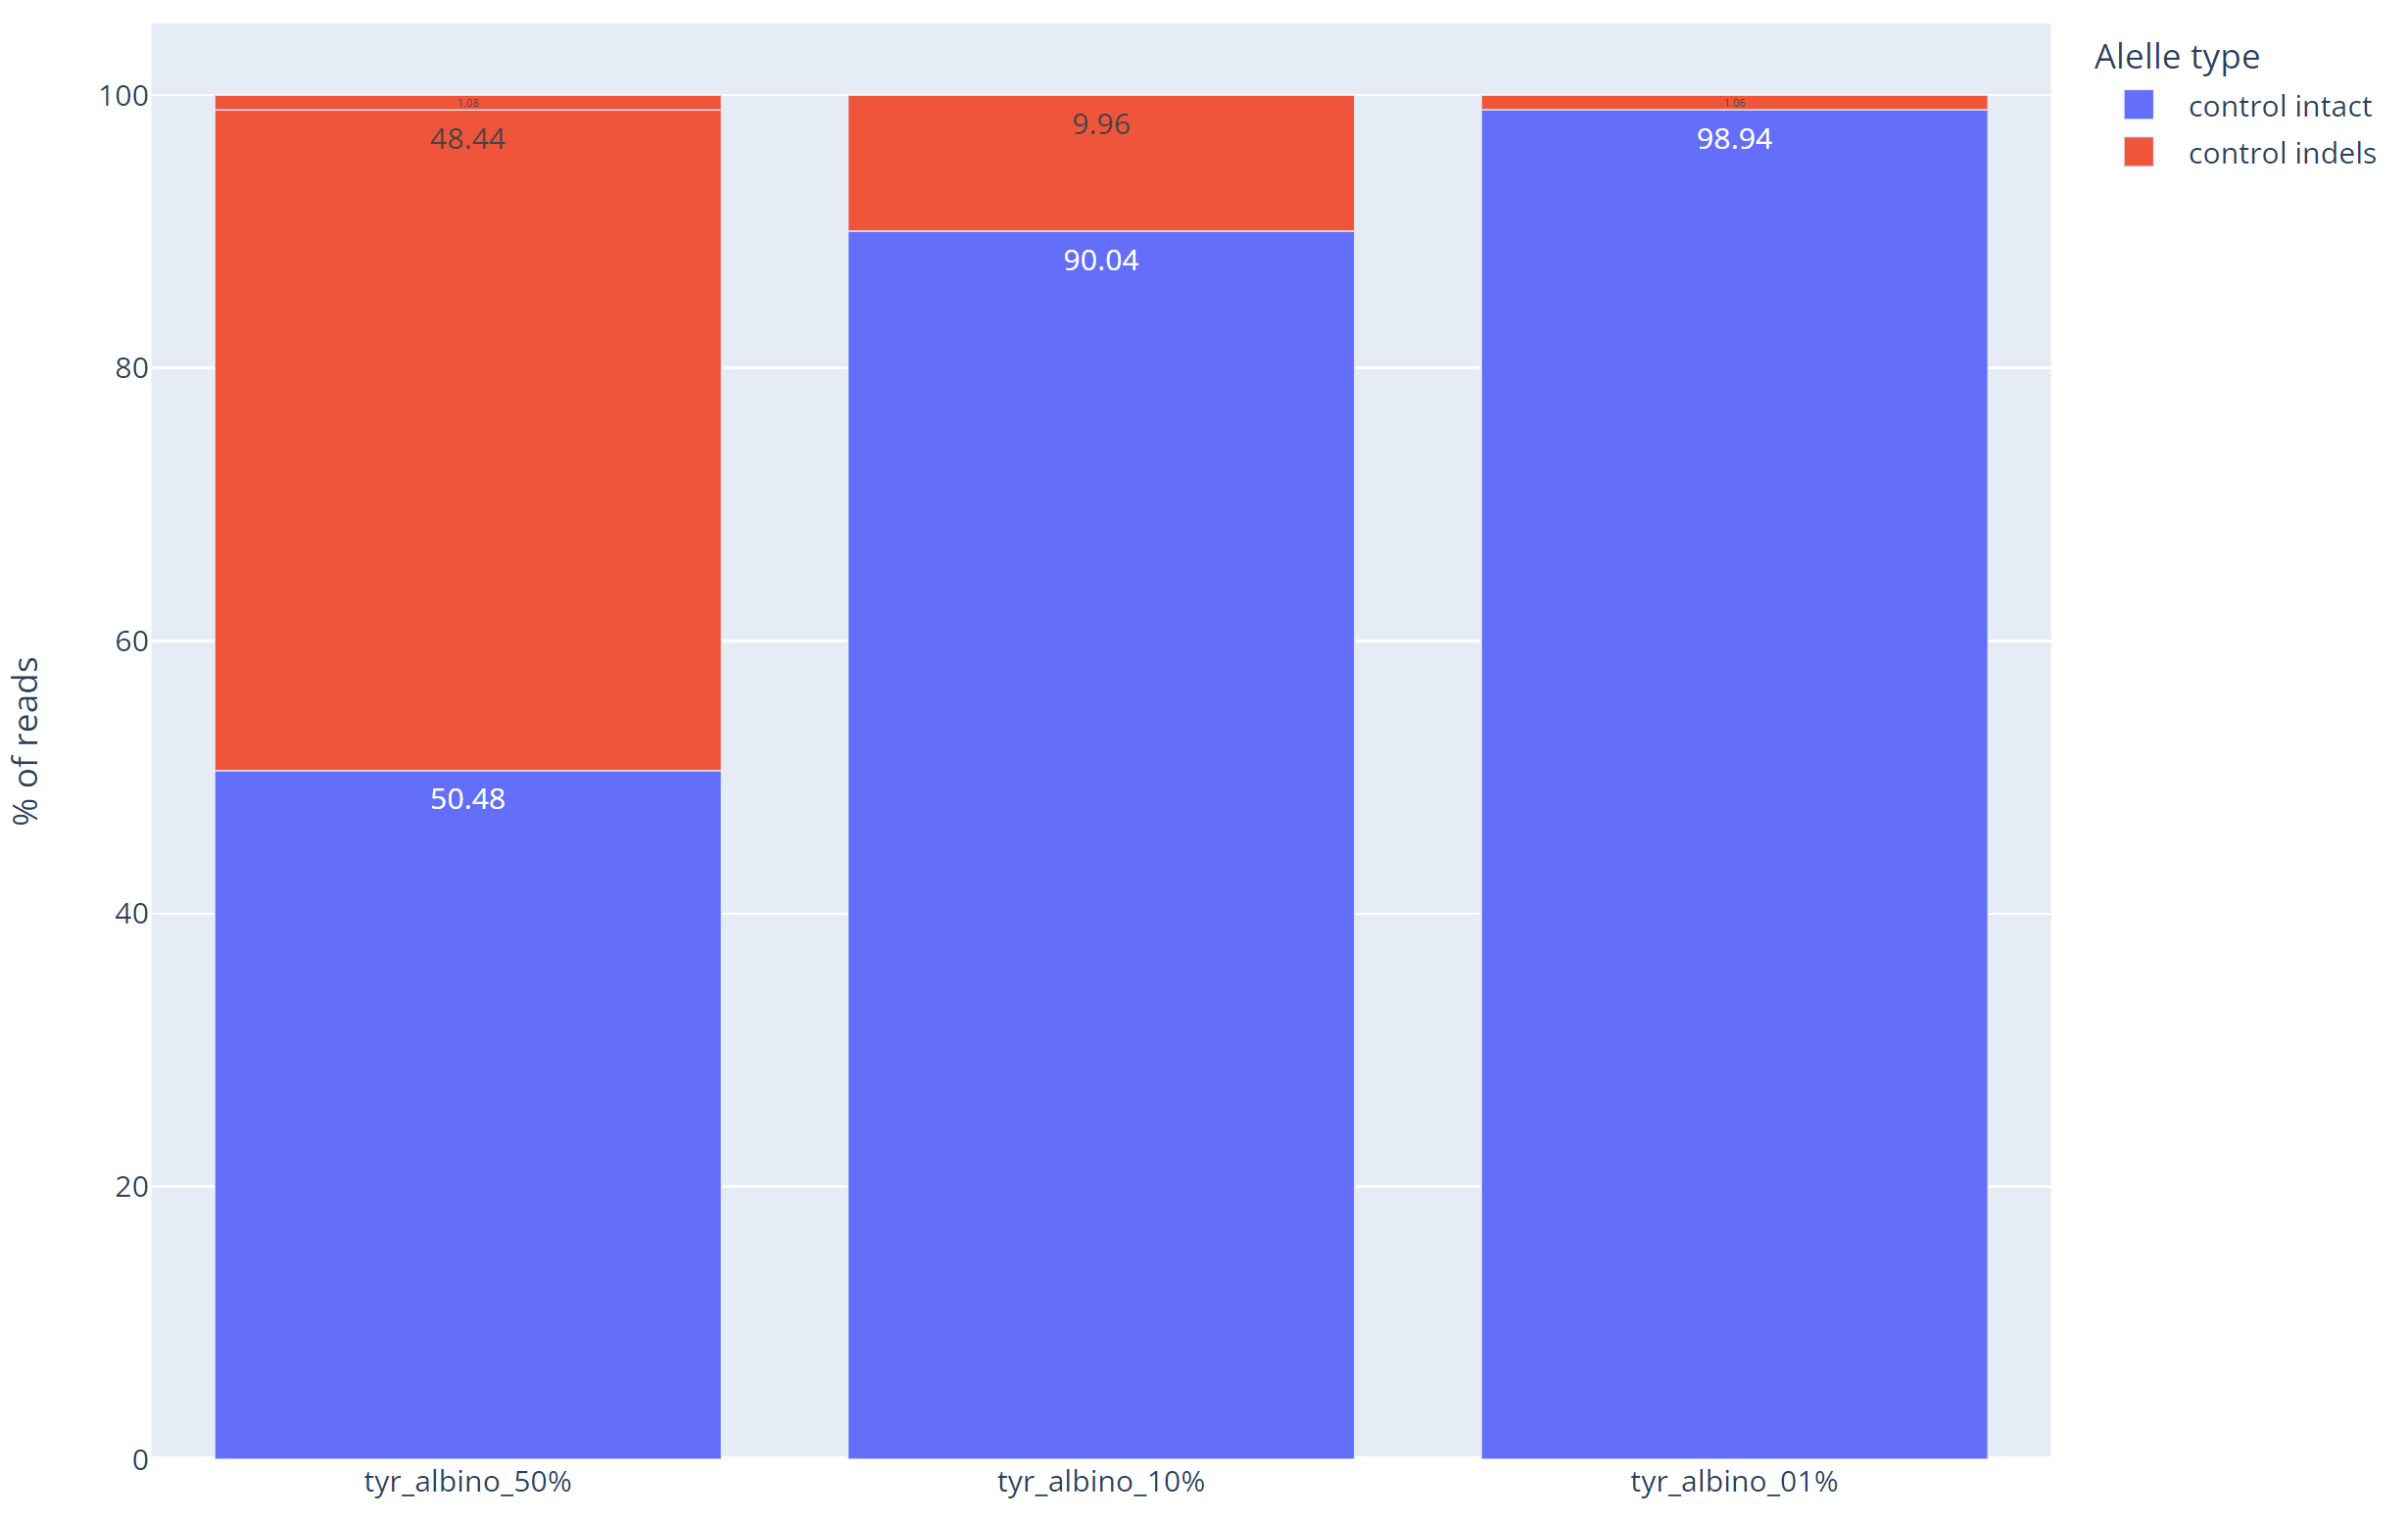

In [91]:
%%bash
rm -rf DAJINResults/single-stx2deletion
rm -rf DAJINResults/.tempdir/single-stx2deletion

time DAJIN2 \
    --name single-stx2deletion \
    --sample "tests/data/knockout/test_barcode25.fq.gz" \
    --control "tests/data/knockout/test_barcode30.fq.gz" \
    --allele "tests/data/knockout/design_stx2.fa" \
    --genome mm10 \
    --threads 10

tests/data/knockout/test_barcode30.fq.gz is now processing...
tests/data/knockout/test_barcode25.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/single-stx2deletion to see the report.

real	3m42.498s
user	46m54.780s
sys	3m30.986s


- きちんと3アレルに分かれています
- コンセンサス配列も大丈夫そうでした

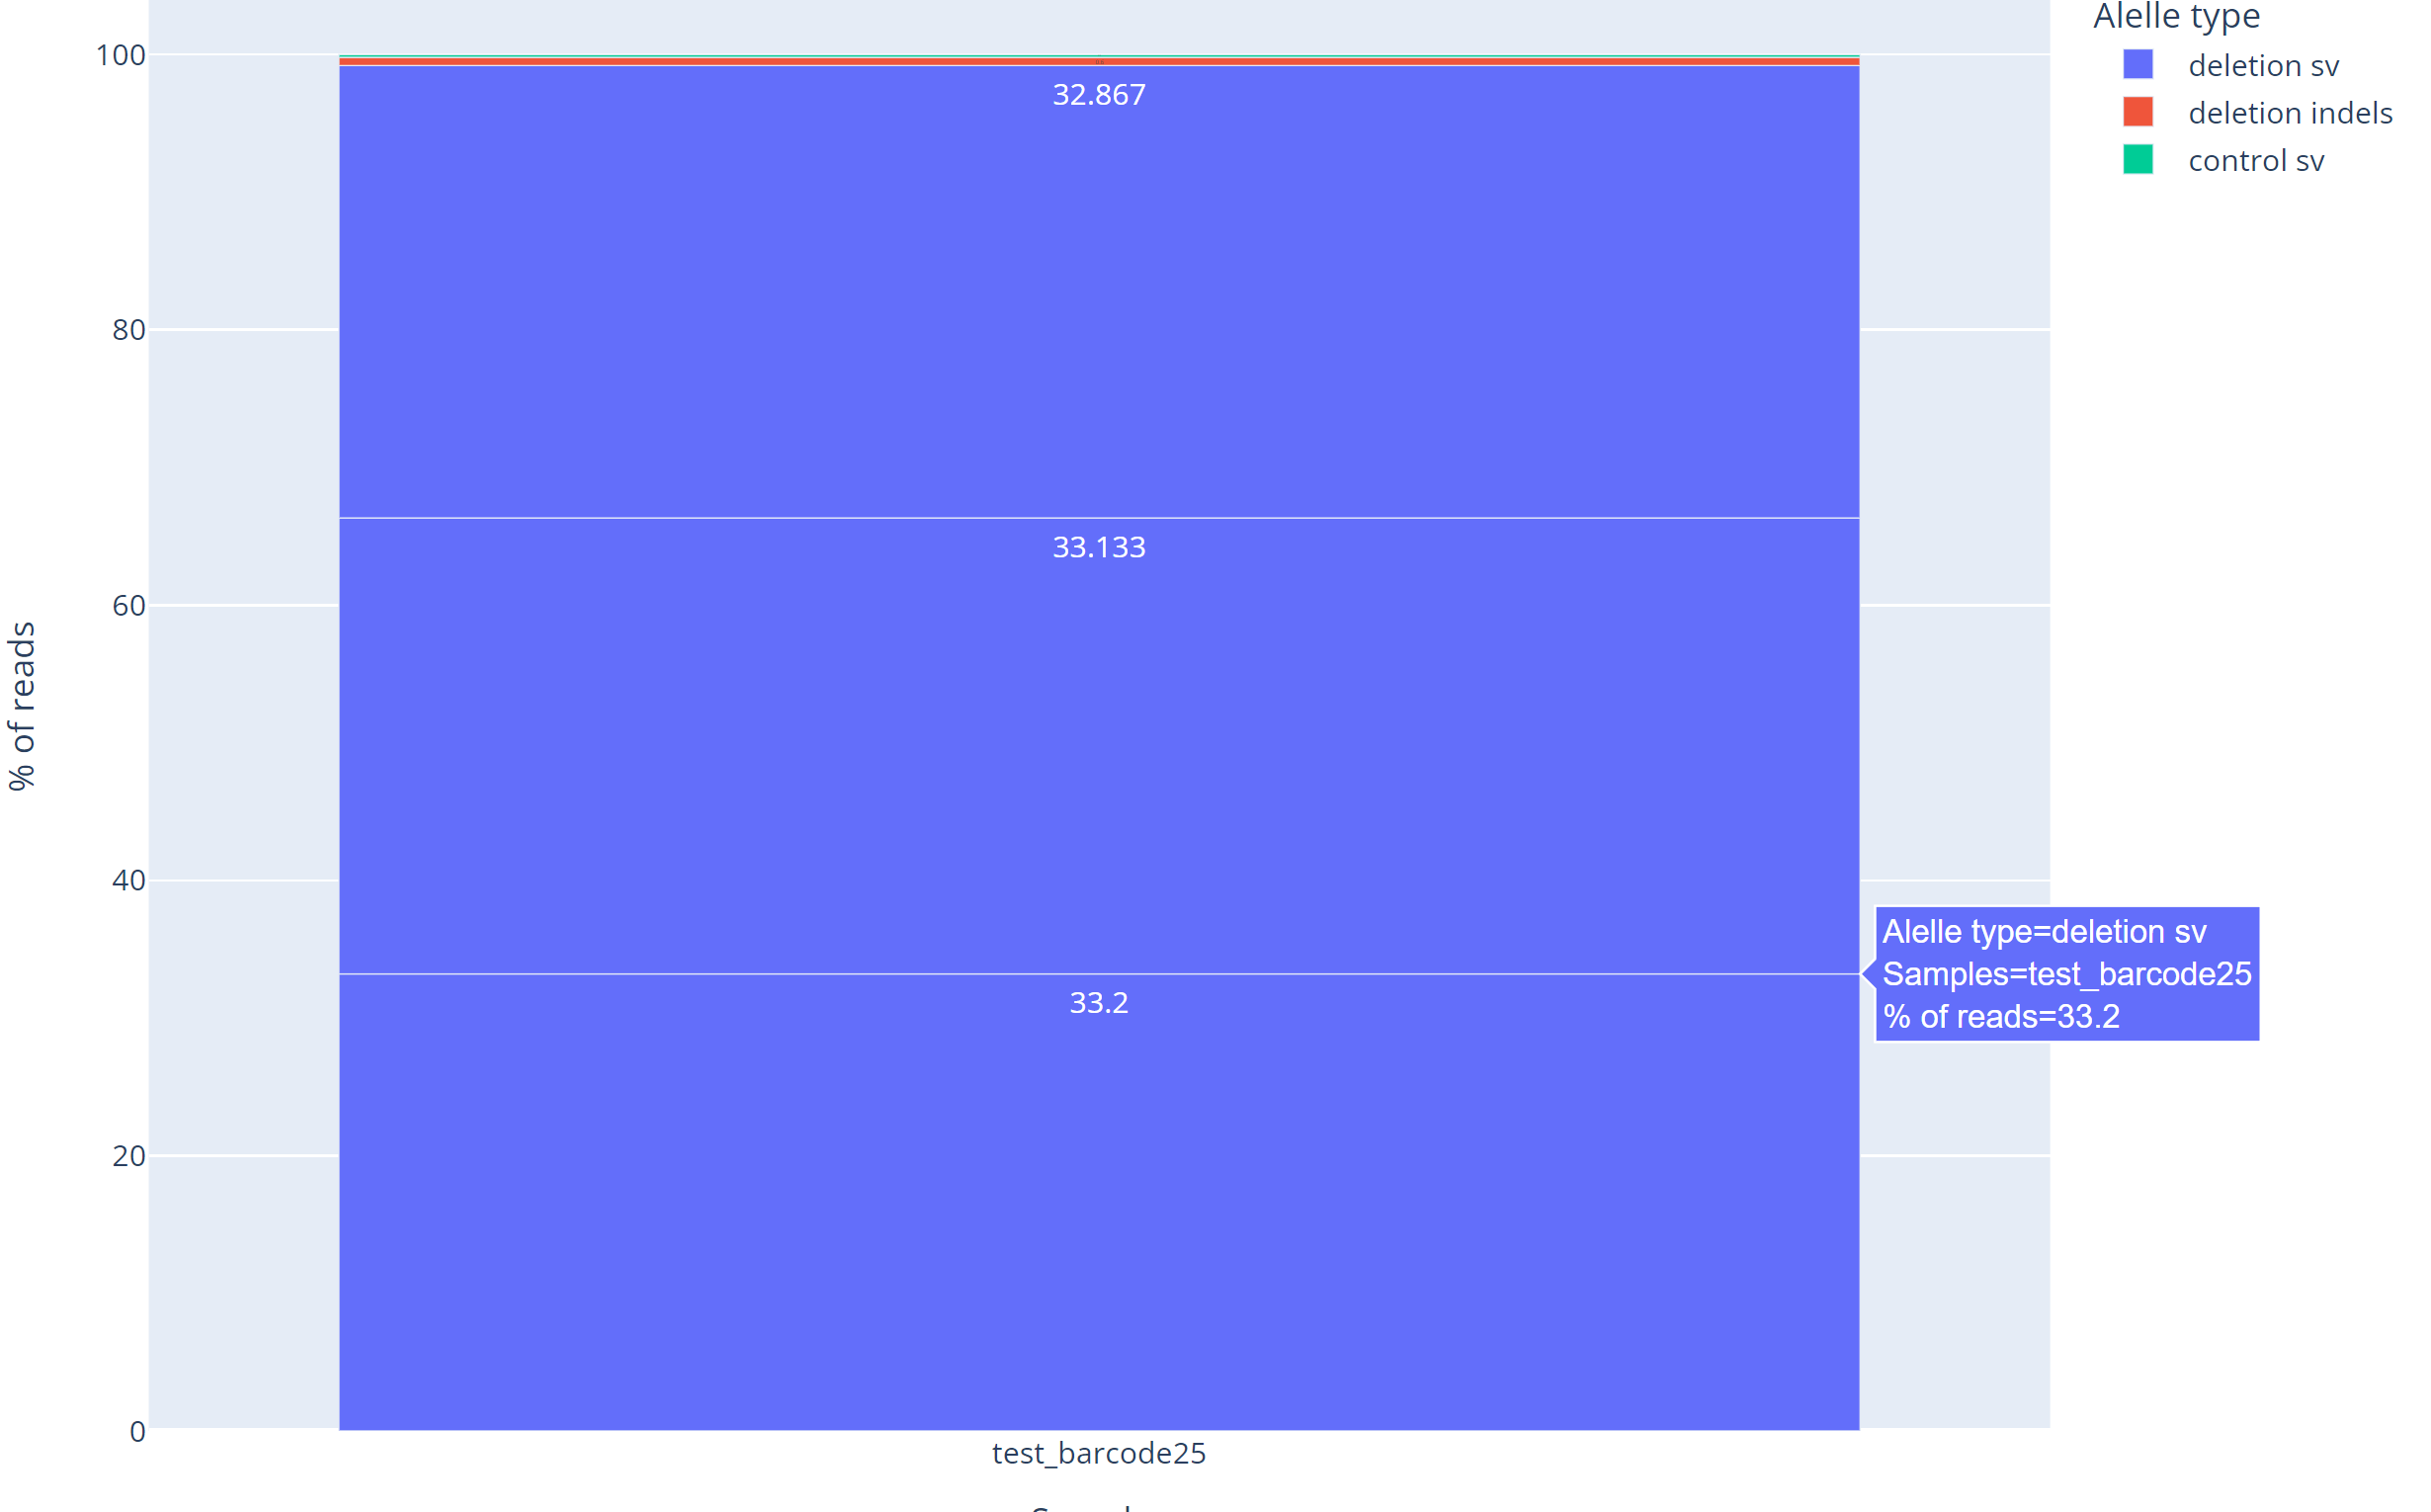

In [92]:
%%bash
rm -rf DAJINResults/single-ayabetask1
rm -rf DAJINResults/.tempdir/single-ayabetask1

time DAJIN2 \
    --name single-ayabetask1 \
    --sample examples/flox-cables2/AyabeTask1/barcode31.fq.gz \
    --control examples/flox-cables2/AyabeTask1/barcode42.fq.gz \
    --allele examples/flox-cables2/AyabeTask1/design_cables2.fa \
    --genome mm10 \
    --threads 10

examples/flox-cables2/AyabeTask1/barcode42.fq.gz is now processing...
examples/flox-cables2/AyabeTask1/barcode31.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/single-ayabetask1 to see the report.

real	1m35.177s
user	18m4.875s
sys	1m52.317s


- Right-loxpこそありませんが、おおむね大丈夫です

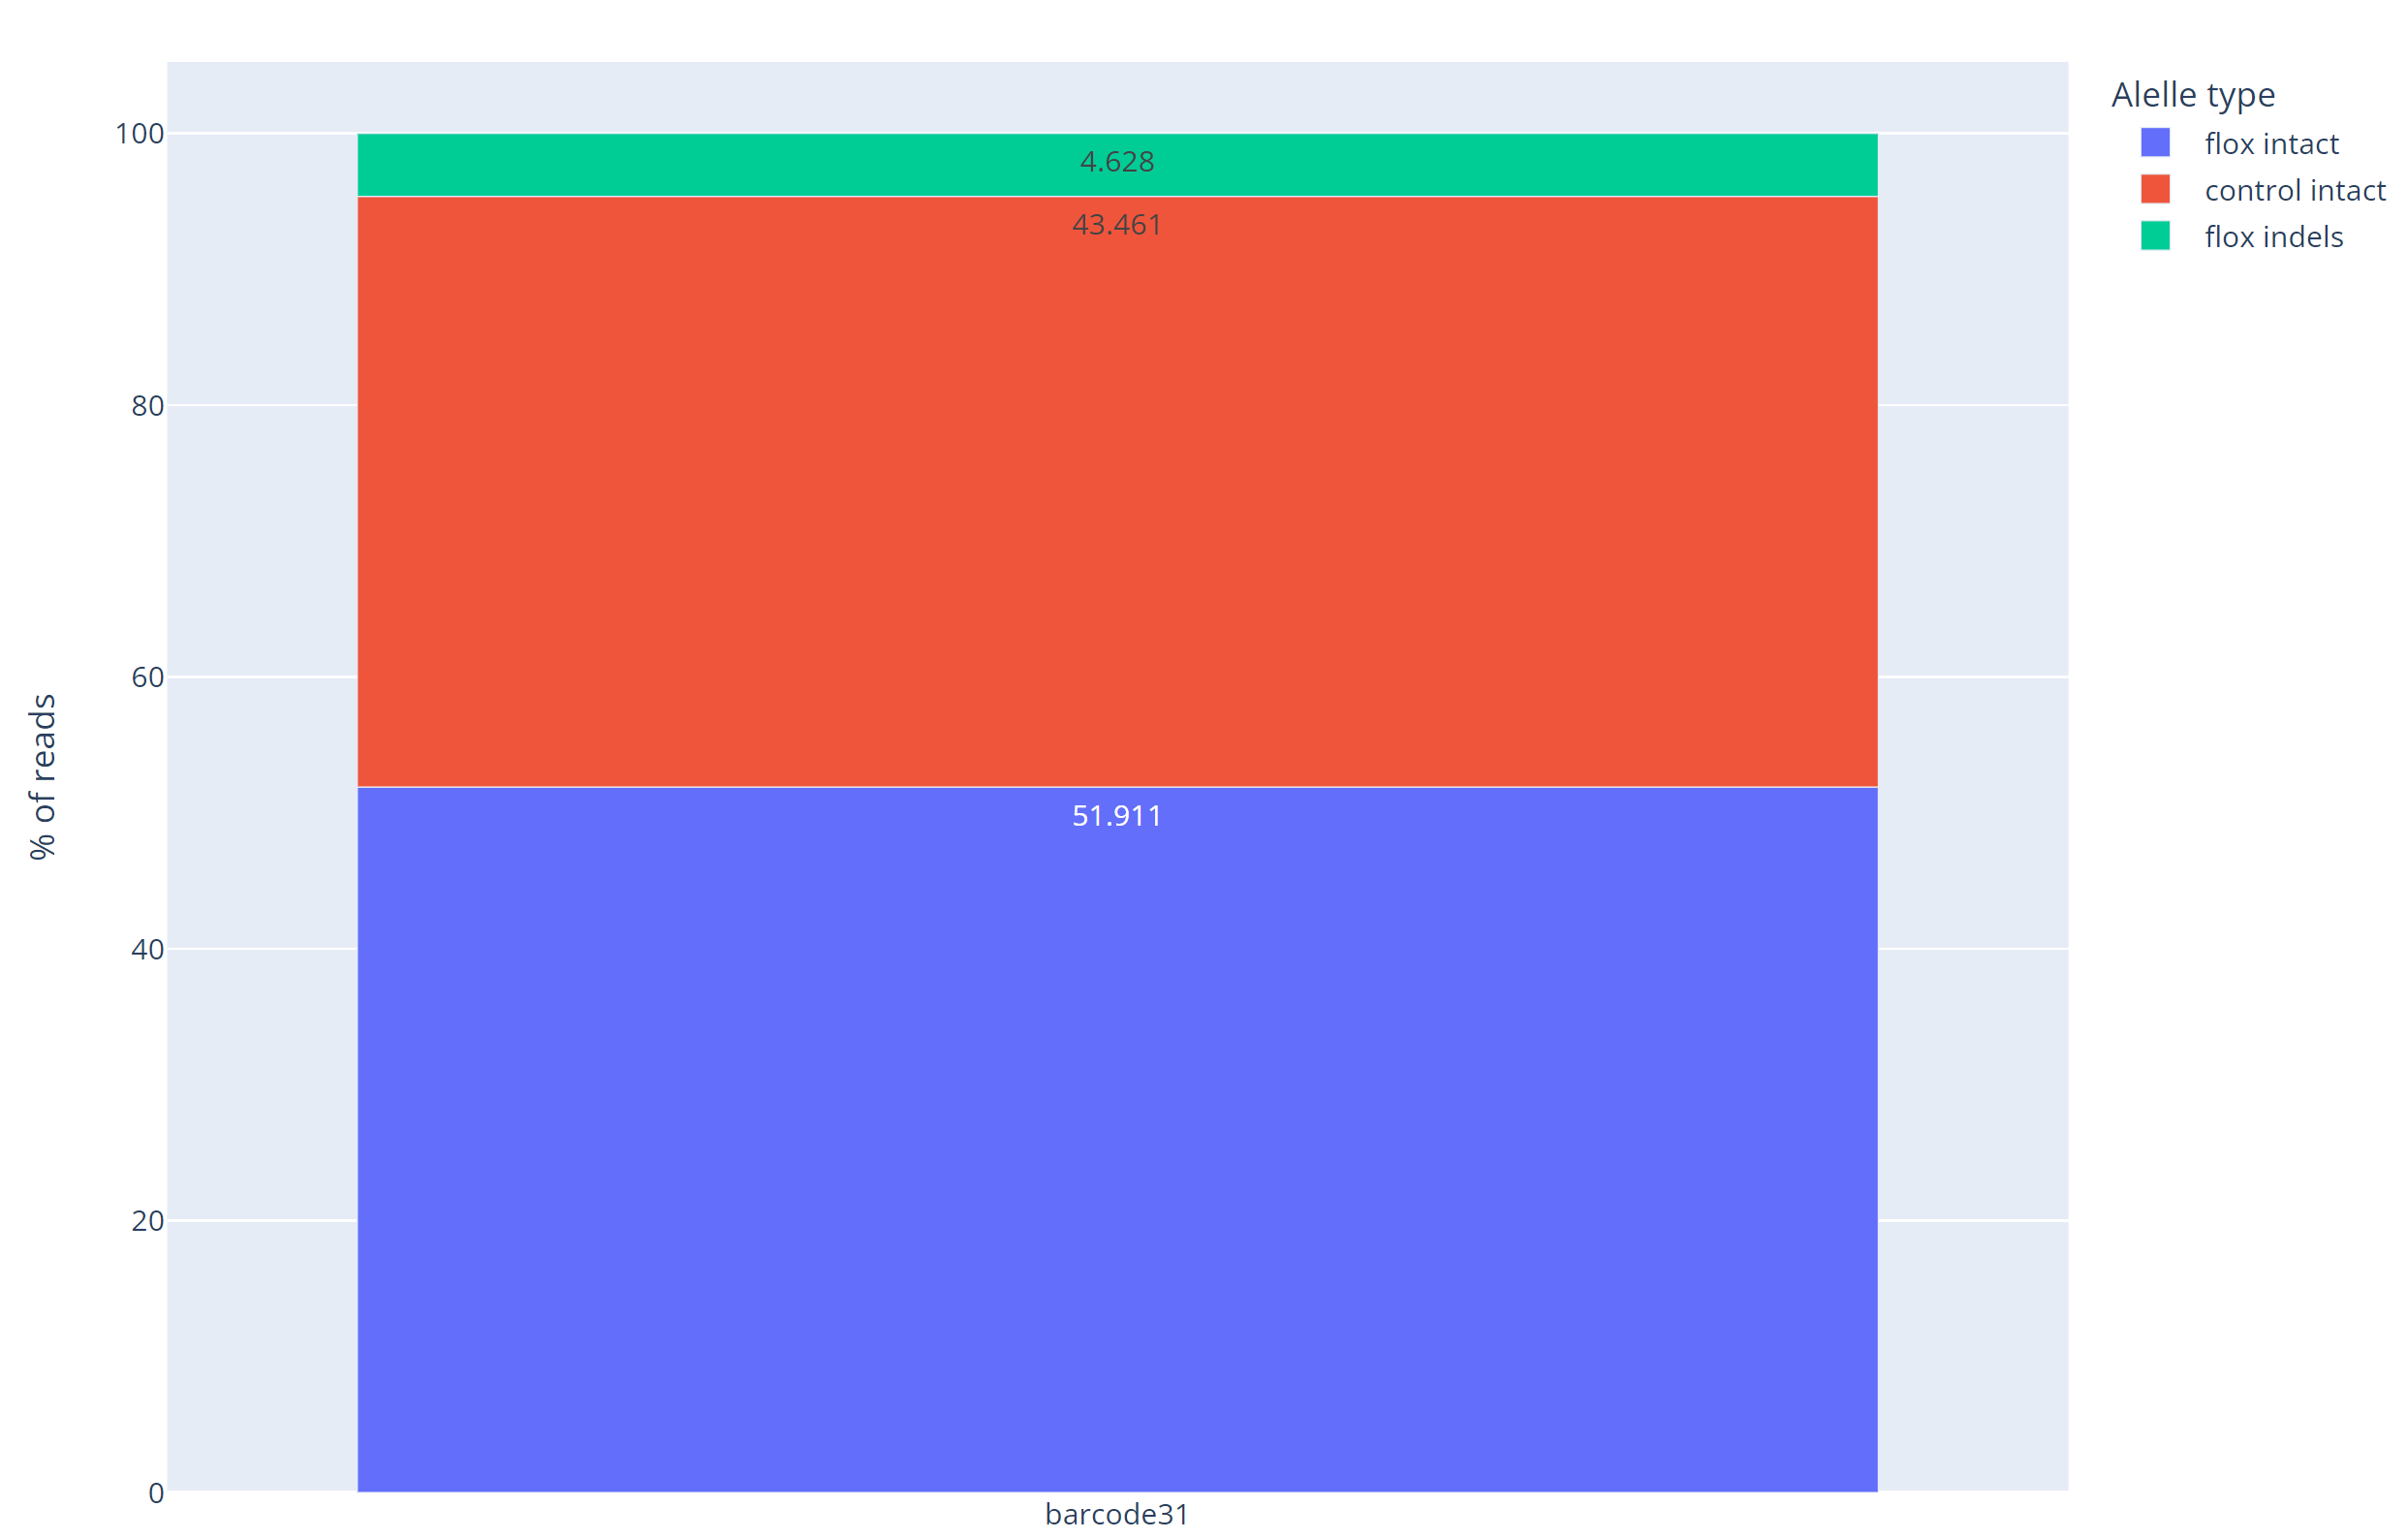

- すこしデバッグします

In [100]:
print(len(mutation_loci))
print(sum(len(v) for v in mutation_loci.values()))

3
242


In [105]:
labels_all = [5,5,5]
max_label = 5
labels = [1] * len(classif_sample)
labels_reorder = _reorder_labels(labels, start=max_label)
max_label = max(labels_reorder)
labels_all.extend(labels_reorder)

In [106]:
print(labels_reorder[:10])
print(labels_all[:10])

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[5, 5, 5, 6, 6, 6, 6, 6, 6, 6]


In [108]:
mutation_loci["del"] == mutation_loci["ins"] == mutation_loci["sub"] == set()

False

In [113]:
x = {"ins": set(), "del": set(), "sub": set()}
print(x["del"] == x["ins"] == x["sub"] == {})
y = {i for i in range(10)}
print(type(y))
print(type(mutation_loci["del"]))

False
<class 'set'>
<class 'set'>


# 👉👉👉 いまここ 👈👈👈

# 👌👌👌 まとめ 👌👌👌


- TyrやStx2のクラスタリングがうまくいかない原因を探索しました
    - `make_score`の引数の順番を間違えていました(control -> sample)
    - 引数の順番を正しく(sample -> control)に直しました
- これまでで一番良い結果が得られました
    - 唯一、Ayabetask1のright-loxpがなくなってしまいました
    - 90%はできたので、いったん無視して次に行っても良いかもしれません

# 次に取り組むこと

+ GUIの見栄え
+ igv.jsの起動
+ VCFによる長鎖挿入・欠失情報の付与
+ Figの作成

### Lists

+ ⬜ Insertionのなかにある変異を同定する手法を考案する
+ ⬜ Ayabe-taks1のright_loxpがいまいちな理由を考察する
+ ✅ 断端リードの扱いをどうするべきか
+ ✅ `SV`の判定をconsensus callのあとにする
+ ✅ Tyrの動作確認
+ ✅ ayabe-task1のleft/right-loxpの検出
+ ✅ mutation_lociをpreprocessで使用したものに変更する
> + ⬜ `preprocess.correct_sequence_error.replace_atmark`のコードがわかりにくい
    + テストを用意してリファクタリングする